# TP 2 - Machine Learning

## Student: Isadora Cardoso

--------------------

The goal of this work is to implement the AdaBoost algorithm, using decision stumps as weak classifier. The evaluation uses k-fold cross-validation, with $k = 5$.

### Introduction

#### AdaBoost

In Machine Learning, Boosting refers to an iterative procedure that constructs a set of base classifiers from training data and performs classification by taking a vote on the predictions made by each base classifier. It is important to note that those base classifiers should be weak ones, which gives the following advantages:

- Speed: simple classifiers does not have many parameters to learn;
- Avoiding overfitting: the classifiers give different hypothesis, which may have great diversity, i.e., the algorithm is always learning. So, by combining different hypothesis from the hypothesis space, it gives a robust final hypothesis.


AdaBoost assigns a weight to each training example and may adaptively change the weight at the end of each boosting round. It adaptively change the distribution of training examples so that the base classifiers will focus on examples that are hard to classify. AdaBoost is represented by the following model:

\begin{equation*}
h(x) = \alpha_1 h_1 (x) + \cdots + \alpha_m h_m (x),
\end{equation*}

where $m$ is the total of classifiers.


AdaBoost is a simple algorithm that:

1. Assign to all examples equal weights, where $\sum_{i=1}^n w_i = 1$. Therefore, we have $w = 1/n$, where $n$ is the size of the data set. It gives to all examples equally likely to be chosen for training;
2. Loop until reached the maximum number of weak classifier (from 1 to $m$):
  - Pick $h_t$ that minimizes the empirical error, $\epsilon_t$, at iteration $t$.
  - Calculate $\alpha^t$:

\begin{equation}
\alpha_t = \frac{1}{2} \log \left( \frac{1 - \epsilon_t}{\epsilon_t} \right),
\end{equation}

where $\epsilon^t$ is the empirical error at iteration $t$.

 - Update the weights, i.e., calculate $w_{t+1}^i$:

\begin{equation}
\sum_{i=1}^n w_{t+1}^i = \frac{w_t^i}{z} e^{-\alpha_t \cdot h_t(x) \cdot y(x)},
\end{equation}

where $y(x)$ returns the correct output, $h_t(x)$ is the prediction by the classifier, and $z$ is a normalizer factor that ensures that $\sum_{i=1}^n w_i = 1$.

Examples that are classified incorrectly will have their weights increased, while those that are classified correctly will have their weights decreased. This forces the classifier to focus on examples that are difficult to classify in subsequent iterations _(Tan et al., 2005)_.

#### Weak Classifier

In this work, we use Decision Stumps, which consists of a tree with only one level. They are one of the simplest classifier, which makes them perfect as weak classifiers in Boosting. The epirical error $\epsilon_t$ for them is the sum of the weights of the misclassified examples.

> The weak learner considers each of the decision stump classifiers and outputs the one with the smallest (weighted) error. In case of ties, it outputs the classifier with the smallest index: $g_1$ is the most preferred while $g_{14}$ is the least preferred. More generally, for each classifier, there is also its “inverse” in the sense that they use the same test but have their labels inverted: the decision-stump branches have their labels inverted. For each odd number $i$, classifier $g_{i+1}$ is the “inverse” of $g_i$ _(ORTIZ, 2005)_.

#### Data set

The data set used here depicts the Tic-Tac-Toe game _(AHA)_. Each example gives a configuration of the game, assuming that the player with "x" plays first. We classify "x wins" (i.e., true when "x" has one of 8 possible ways to create a "three-in-a-row") as the positives instances and the negatives are "o wins". It also has a feature "b", when there is nothing in the position.

#### Cross-Validation

In Cross-Validation, we randomly split the data into $k$ folds, using $k-1$ to train and 1 to test. It helps the data generalization, since the model is trained and tested in different data sets, avoiding overfitting.


###### References

TAN, P. STEINBACH, M. KUMAR, V. Introduction to Data Mining, (First Edition). Addison-Wesley Longman Publishing Co., Inc., Boston, MA, USA, 2005.

AHA, D. Tic-Tac-Toe Endgame Data Set. Available in: https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame

ORTIZ, L. Boosting: Review Problem. 2005. Available in: http://www-personal.umd.umich.edu/~leortiz/teaching/6.034f/Fall05/boost/boost_prob_review.pdf

----------------

### Implementation

In [2]:
# Import the necessary libraries

import csv
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from random import seed
from random import randrange

%matplotlib inline

seed(123)

The classes in the data set are described as 'positive', when "x" wins, and 'negative', when "o" wins. We change this to 1 (positive) and -1 (negative), since it is easier to handle.

In [4]:
# Load the data set

with open('tic-tac-toe.csv') as data_file:
    data = []
    dataset = csv.reader(data_file)
    for row in dataset:
        if row[-1] == 'positive':
            row[-1] = int(1)
        else:
            row[-1] = int(-1)
        data.append(row)
        
data_file.close()

data = np.array(data)

We will first implement the decision stump. Since we have 3 possible values (x,o,b) for 9 possible positions, we will have 54 stumps (27 positives and 27 negatives). We run all the decision stumps and choose the one with the smallest error.

In [5]:
# Stump to train
# The input is the data, the index of the values, the values, and the inverse.

def decision_stump(data, index, value, inverse):
    answer = np.ones(len(data))
    
    if inverse:
        answer[data[:,index] == value] = -1.0
    else:
        answer[data[:,index] != value] = -1.0 
        
    return answer


# Stump to test
# The input is the example, the index of the values, the values, and the inverse.

def predict_stump(example, index, value, inverse):
    answer = 1.0
    
    if inverse and example[index] == value:
        answer = -1.0
    elif not inverse and example[index] != value:
        answer = -1.0
        
    return answer


# Get the best stump
# The input is the data, the classes, and the weights.

def best_stump(data, classes, weights):
    
    rows, columns = np.array(data).shape
    best_stump = {}
    best_predict = np.zeros(rows)
    
    min_error = float('inf')
    
    for index in range(columns - 1):
        for value in ['x', 'o', 'b']:
            for inverse in [True, False]:
                predict = decision_stump(data, index, value, inverse)
                
                error = np.ones(rows, dtype=np.int)
                error[predict == classes] = 0
                weighted_error = np.dot(weights, error)
                
                if weighted_error < min_error:
                    min_error = weighted_error

                    best_predict = predict.copy()
                    best_stump['index'] = index
                    best_stump['value'] = value
                    best_stump['inverse'] = inverse
    
    return best_stump, best_predict, min_error

We will implement the AdaBoost model. We can put big iterations values since stumps are very simple and execute fast. We add a small value in alpha because sometimes it is zero, which gives errors.

In [6]:
# AdaBoost
# The input is the data and number of iterations

def adaboost(data, num_iter = 1000):
    classifiers = []
    iterat_error = []
    stump_error = []
    n = len(data)
    
    weights = np.array([1.0/n for x in range(n)])
    classes = np.array(np.array(data)[:,-1], dtype=np.float)
    classifiers_predict = np.zeros(n)
    
    for i in range(num_iter):
        stump, predict, error = best_stump(data, classes, weights)
        
        # Add small value for stability
        alpha = float(0.5*np.log((1.0-error) / (error+1e-15)))
        stump['alpha'] = alpha
        classifiers.append(stump)

        weights = np.multiply(weights, np.exp(np.multiply(-alpha*classes, predict)))
        weights = weights/weights.sum()

        classifiers_predict += predict * alpha
        
        # sign function returns -1 if x < 0, 0 if x == 0, and 1 if x > 0
        classifiers_error = np.multiply(np.sign(classifiers_predict) != classes, np.ones(n))
        classifiers_error = classifiers_error.sum()/n
        
        iterat_error.append(classifiers_error)
        stump_error.append(error)
        
    return classifiers, iterat_error, stump_error

Note we write two classes to predict data. The first one (predict) works as a "private class" (same concept as in java language), being used only to help the "main" predict function. The same happens for cross validation.

In [7]:
# Predict the output for an example

# this class is like a private class, being called just by the class below
def predict(example, boost):
    classifiers_predict = 0
    
    for h in range(len(boost)):
        predict = predict_stump(example, boost[h]['index'], boost[h]['value'], boost[h]['inverse'])
        classifiers_predict += boost[h]['alpha'] * predict

    return np.sign(classifiers_predict)



def test_classifier(data, boost):
    
    n = data.shape[0]  
    classes = np.array(data[:,-1], dtype=np.float)
    predicted_classes = np.zeros(n)
    error = np.zeros(n)
    
    for index in range(n):
        predicted_classes[index] = predict(data[index,:], boost)
    
    error = np.multiply(np.sign(predicted_classes) != classes, np.ones(n))
    
    return error.sum()/n

In order to evaluate better our AdaBoost model, we use k-fold cross-validation, with k = 5.

In [8]:
# Split the data into k-folds

# this class is like a private class, being called just by the class below
def folds_split(data, n_folds):
    splits = list()
    data_copy = list(data)
    fold_size = int(len(data) / n_folds)
    
    for i in range(n_folds):
        fold = list()
        
        while len(fold) < fold_size:
            index = randrange(len(data_copy))
            fold.append(data_copy.pop(index))
            
        splits.append(fold)
        
    return splits



def cross_validation(data, n_folds):
    k_folds = folds_split(data, n_folds)

    data_splitted = []

    for fold in range(len(k_folds)):
        train = []
        train_id = list(range(0, fold)) + list(range(fold + 1, len(k_folds)))

        test = k_folds[fold]

        for index in train_id:
            for item in k_folds[index]:
                train.append(item)

        data_splitted.append((train,test))
        
    return data_splitted

In [47]:
# Run the AdaBoost model in Tic-Tac-Toe data set

n_folds = 5
n_iterations = 300
test_error = []

k_folds = cross_validation(data, n_folds)

# we have to add one to not stop before we want
for iteration in range(50,(n_iterations+1),50):

    if iteration < n_iterations:
        error = 0

        for train, test in k_folds:
            model, err, st_err = adaboost(np.array(train), iteration)
            error += test_classifier(np.array(test), model)

        test_error.append(error/n_folds)

    else:
        train_error = np.zeros(iteration)
        stump_error = np.zeros(iteration)
        error = 0

        for train, test in k_folds:
            model, err, st_err = adaboost(np.array(train), iteration)

            train_error = np.add(train_error, err)
            stump_error = np.add(stump_error, st_err)

            error += test_classifier(np.array(test), model)

        test_error.append(error/n_folds)
        train_error = train_error/n_folds
        stump_error = stump_error/n_folds

In [52]:
# Plot training errors

def plot_train_error(n_iterations):
    fig, ax = plt.subplots()

    iteration = range(1,(n_iterations+1))
    ax.plot(iteration,train_error,'-', linewidth = 2, label=u'Ensemble Training Error Rate', color='tomato')
    ax.plot(iteration,stump_error,'-', linewidth = 2, label=u'Stump Training Error Rate', color='royalblue')

    ax.ticklabel_format(useOffset=False, style='plain')

    ax.set_ylim([0,0.5])
    ax.set_xlim([0,(n_iterations+10)])
    ax.xaxis.grid()

    ax.legend(loc=5)

    plt.title(u"Adaboost with 5-Fold Cross Validation")

    plt.ylabel(u"Error Rate")
    plt.xlabel(u"Iteration")

    plt.show()
 

#
# Plot test error

def plot_test_error(n_iterations):
    fig, ax = plt.subplots()

    iteration = range(50,(n_iterations+1),50)
    ax.plot(iteration,test_error,'-', linewidth = 2, label=u'Ensemble Test Error Rate', color='tomato')

    ax.ticklabel_format(useOffset=False, style='plain')

    ax.set_ylim([0,0.2])
    ax.xaxis.grid()

    ax.legend()

    plt.title(u"Adaboost with 5-Fold Cross Validation")

    plt.ylabel(u"Error Rate")
    plt.xlabel(u"Iteration")

    plt.show()

First, we examine the training error. The blue line gives the training error by AdaBoost. The first decision stump predicts with about 30% of error. If we do not change the weights of the data set, we would always get this error rate, since we would always get the same classifier. However, as we add more stumps (with more iterations), we gain more accuracy, up to 50%. Also, we can see that with more stumps, the traning error rate is smaller. Around the 200 iteration, this rate is getting steady. So, we conclude that 200 iterations are enough to this data to minimize the training error.

In the second figure, we can see the ensemble test error rate. Around the 150 iterations, we have about 5% of error. When the training error is like converging, around 200 iterations, the test error is about 2.5%, being smaller with more iterations. However, an accuracy of almost 98% is a great result.

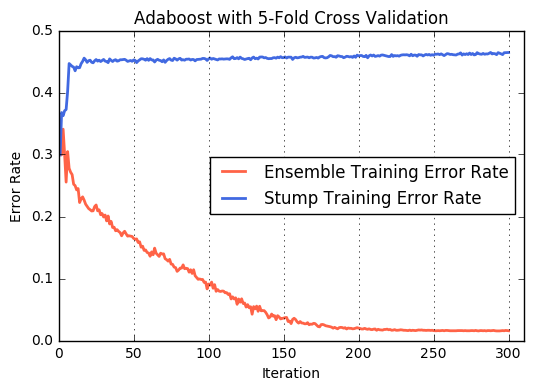

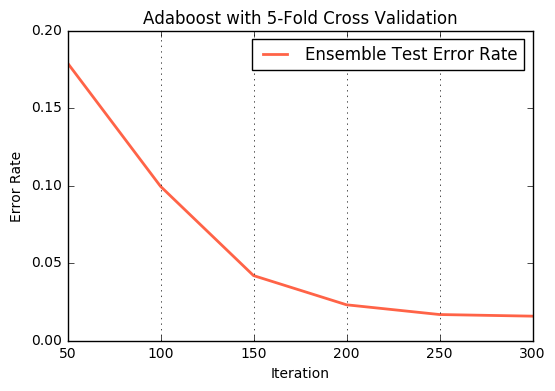

In [53]:
plot_train_error(300)
plot_test_error(300)

### Conclusion

In this work we implement and evaluate an AdaBoost model, which ensembles several weak classifiers in order to have a strong classifier. We use decision stumps, that are tree with one level, as the weak classfiers. Also, we use k-fold cross-validation with k = 5 to evaluate the model.

We can note that the only parameter to AdaBoost, the number of weak classifiers, is extremely important to the result. In this work, we use 300 weak classifiers. Even though the accuracy for each classifier is low, the model that ensemble them achieves great results, with almost 98% of accuracy.

Furthermore, this work helped to understand how the AdaBoost works and showed that complexity does not mean better accuracy. So we conclude that the work achieved very well its purpose.